# **Fine-tuning Resnet-50 for Image Classification**

This notebook shows how to fine-tune Microsoft's Resnet-50 for Image Classification on the [SaladSlayer/twin_matcher_data](https://huggingface.co/datasets/SaladSlayer00/twin_matcher_data/viewer/default/train?p=90) dataset. This is the core of the Twin Matcher project.
This notebook leverages TensorFlow's [image](https://www.tensorflow.org/api_docs/python/tf/image) module for applying data augmentation.


In [ ]:
model_checkpoint = "microsoft/resnet-50" # pre-trained model from which to fine-tune
batch_size = 32 # batch size for training and evaluation

Before we start, let's install the `datasets` and `transformers` libraries.

In [ ]:
!pip install -q datasets transformers

In [ ]:
!pip install datasets==1.14.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.4/290.4 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 7.1 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.19.4
    Uninstalling huggingface-hub-0.19.4:
      Successfully uninstalled huggingface-hub-0.19.4
  Attempting uninstall: datasets
    Found existing installation: datasets 2.16.0
    Uninstalling datasets-2.16.0:
      Successfully uninstalled datasets-2.16.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tokenizers 0.15.0 requires huggingface_hub<1.0,>=0.16.4, but you have huggingface-hub 0.0.19 which is incompatible.
transformers 4.35.2 requires huggingface-hub<1.0,>=0.16.4, but you have huggingface-hub 0.0.19 which is incompatible.


We need to access HuggingFace to be able to upload model and checkpoints.

In [ ]:
from huggingface_hub import notebook_login

notebook_login()


Then we need to install Git-LFS to upload model checkpoints:

In [ ]:
%%capture
!git lfs install
!git config --global credential.helper store

In [ ]:
from transformers.utils import send_example_telemetry

send_example_telemetry("image_classification_notebook", framework="tensorflow")

In [ ]:
from huggingface_hub import Repository
repo = Repository(local_dir="image_classification_resnet", clone_from="SaladSlayer00/image_classification_resnet")
repo.git_pull()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:127: FutureWarning: 'Repository' (from 'huggingface_hub.repository') is deprecated and will be removed from version '1.0'. Please prefer the http-based alternatives instead. Given its large adoption in legacy code, the complete removal is only planned on next major release.
For more details, please read https://huggingface.co/docs/huggingface_hub/concepts/git_vs_http.
Cloning https://huggingface.co/SaladSlayer00/image_classification_resnet into local empty directory.


## Fine-tuning a model on an image classification task

In this notebook, we will see how to fine-tune one of the [🤗 Transformers](https://github.com/huggingface/transformers) vision models on an Image Classification dataset.


### Loading the dataset

We will use the [🤗 Datasets](https://github.com/huggingface/datasets) library's [ImageFolder](https://huggingface.co/docs/datasets/v2.0.0/en/image_process#imagefolder) feature to download our custom dataset into a DatasetDict.

In this case, the twin_matcher_data is uploaded on HuggingFace, so we can directly pull it using the datasets library. It's a dataset composed of 105 celebrities folders, each containing (160, 160) images.

In [ ]:
from datasets import load_dataset

dataset = load_dataset("SaladSlayer00/twin_matcher_data")


Let us also load the Accuracy metric, which we'll use to evaluate our model both during and after training.

In [ ]:
from datasets import load_metric

metric = load_metric("accuracy")

/usr/local/lib/python3.10/dist-packages/datasets/load.py:752: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.16.0/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


The `dataset` object itself is a [`DatasetDict`](https://huggingface.co/docs/datasets/package_reference/main_classes.html#datasetdict), which contains one key per split (in this case, only "train" for a training split).

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 17334
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 200
    })
})

To access an actual element, we need to select a split first, then give an index:

In [ ]:
example = dataset["train"][10]
example

{'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=160x160>,
 'label': 'Megan Fox'}

Each example consists of an image and a corresponding label. We can also verify this by checking the features of the dataset:

In [ ]:
dataset["train"].features

{'image': Image(decode=True, id=None), 'label': Value(dtype='string', id=None)}

The cool thing is that we can directly view the image (as the 'image' field is an [Image feature](https://huggingface.co/docs/datasets/package_reference/main_classes.html#datasets.Image)), as follows:

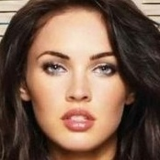

In [ ]:
example['image']

Let's make it a little bigger as the images in the twin_matcher_data dataset are of low resolution:

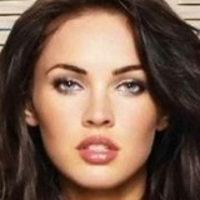

In [ ]:
example['image'].resize((200, 200))

Let's print the corresponding label:

In [ ]:
example['label']

'Megan Fox'

The 'label' fields are encoded into strings for convenience:

In [ ]:
dataset["train"].features["label"]

Value(dtype='string', id=None)

Let's create an `label2id` dictionary to decode them back to integers and see what they are. The inverse `id2label` will be useful too, when we load the model later.

In [ ]:
labels = dataset["train"]["label"]

label2id, id2label = dict(), dict()

for i, label in enumerate(labels):
    label2id[label] = i
    id2label[i] = label

id2label[5]

'Emilia Clarke'

### Preprocessing the data

Before we can feed these images to our model, we need to preprocess them.

We can resize them to a particular size and normalize the color channels (R,G,B) using a mean and standard deviation.

In addition,we perform **data augmentation** during training (like random cropping and flipping) to make the model more robust and achieve higher accuracy. Data augmentation is also a great technique to increase the size of the training data.

We will use `tf.image` for the image transformations/data augmentation. We instantiate a feature extractor with the `AutoFeatureExtractor.from_pretrained` method.

In [ ]:
from transformers import AutoFeatureExtractor

feature_extractor = AutoFeatureExtractor.from_pretrained(model_checkpoint)
feature_extractor

/usr/local/lib/python3.10/dist-packages/transformers/models/convnext/feature_extraction_convnext.py:28: FutureWarning: The class ConvNextFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ConvNextImageProcessor instead.
  warnings.warn(


ConvNextFeatureExtractor {
  "crop_pct": 0.875,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "feature_extractor_type": "ConvNextFeatureExtractor",
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_processor_type": "ConvNextFeatureExtractor",
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "resample": 3,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "shortest_edge": 224
  }
}

The Datasets library is made for processing data very easily. We can write custom functions, which can then be applied on an entire dataset (either using `.map()` or `.set_transform()`).

Here we define 2 separate functions, one for training (which includes data augmentation) and one for validation (which only includes resizing, center cropping and normalizing).

In [ ]:
import numpy as np
import tensorflow as tf
from keras import backend


def normalize_img(img, mean, std):
    mean = tf.constant(mean)
    std = tf.constant(std)
    return (img - mean) / tf.maximum(std, backend.epsilon())


def get_resize_shape(img, size):
    if isinstance(size, tuple):
        return size

    height, width, _ = img.shape
    target_height = int(size * height / width) if height > width else size
    target_width = int(size * width / height) if width > height else size
    return (target_height, target_width)


def get_random_crop_size(img, scale=(0.08, 1.0), ratio=(3/4, 4/3)):
    height, width, channels = img.shape
    img_ratio = width / height
    crop_log_ratio = np.random.uniform(*np.log(ratio), size=1)
    crop_ratio = np.exp(crop_log_ratio)
    crop_scale = np.random.uniform(*scale, size=1)

    # Make sure the longest side is within the image size
    if crop_ratio < img_ratio:
        crop_height = int(height * crop_scale)
        crop_width = int(crop_height * crop_ratio)
    else:
        crop_width = int(width * crop_scale)
        crop_height = int(crop_width / crop_ratio)
    return (crop_height, crop_width, channels)


def train_transforms(image, size=200):
    image = tf.keras.utils.img_to_array(image)
    image = tf.image.resize(
        image,
        size=(size, size),
        method=tf.image.ResizeMethod.BILINEAR
    )
    image = tf.image.random_flip_left_right(image)
    image /= 255
    image = normalize_img(
        image,
        mean=feature_extractor.image_mean,
        std=feature_extractor.image_std
    )
    # All image models take channels first format: BCHW
    image = tf.transpose(image, (2, 0, 1))
    return image


def val_transforms(image, size=200):
    image = tf.keras.utils.img_to_array(image)
    resize_shape = get_resize_shape(image, feature_extractor.size)
    image = tf.image.resize(
        image,
        size=(size,size),
        method=tf.image.ResizeMethod.BILINEAR
    )

    image /= 255
    image = normalize_img(
        image,
        mean=feature_extractor.image_mean,
        std=feature_extractor.image_std
    )
    # All image models take channels first format: BCHW
    image = tf.transpose(image, (2, 0, 1))
    return image


def preprocess_train(example_batch):

    example_batch['pixel_values'] = [
        train_transforms(image.convert("RGB")) for image in example_batch["image"]
    ]
    return example_batch


def preprocess_val(example_batch):

    example_batch['pixel_values'] = [
        val_transforms(image.convert("RGB")) for image in example_batch["image"]
    ]
    return example_batch

Let's quickly visualise some example outputs from our processing pipeline.

Part of the processing pipeline rescales them between [0, 1] and normalizes them. This results in pixel values having negative values. To easily visualise and compare the original images and augmentations we undo this normalization and rescaling here.

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

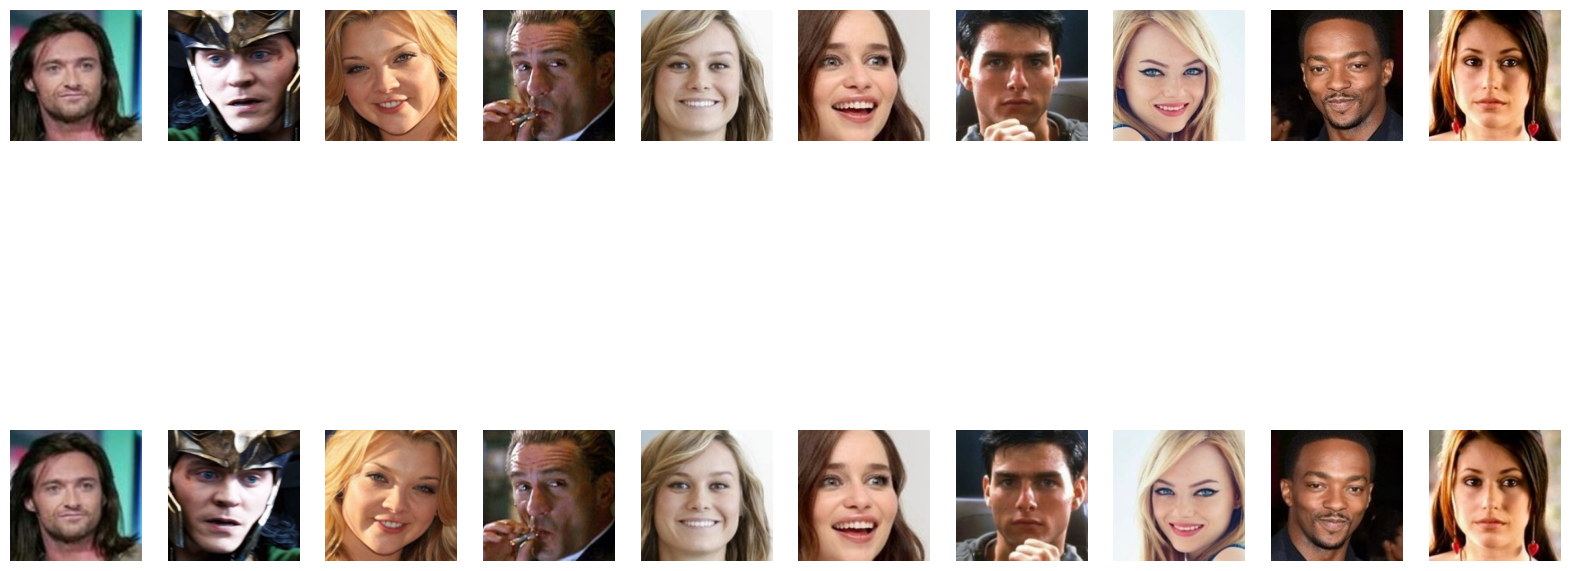

In [ ]:
def unnormalize_img(img, mean, std):
    img = (img * std) + mean
    return img


def process_for_plotting(img):
    img = img.numpy()
    img = img.transpose(1, 2, 0)
    img = unnormalize_img(
        img=img,
        mean=feature_extractor.image_mean,
        std=feature_extractor.image_std
    )
    img = img * 255
    img = img.astype(int)
    return img


n = 10
fig, ax = plt.subplots(2, n, figsize=(20, 10))


for i in range(n):
    orig_img = dataset['train'][i]['image']
    proc_img = train_transforms(orig_img)

    orig_img = np.array(orig_img.convert("RGB"))

    proc_img = process_for_plotting(proc_img)

    ax[0][i].imshow(orig_img)
    ax[1][i].imshow(proc_img)
    ax[0][i].axis('off')
    ax[1][i].axis('off')

Next, we can preprocess our dataset by applying these functions.

In [ ]:
def label_to_int(example):
    example['label'] = label2id[example['label']]
    return example

dataset = dataset.map(label_to_int)

In [ ]:
# split up training into training + validation
splits = dataset["train"].train_test_split(test_size=0.1)
train_ds = splits['train']
val_ds = splits['test']

In [ ]:
train_ds.set_transform(preprocess_train)
val_ds.set_transform(preprocess_val)

Let's access an element to see that we've added a "pixel_values" feature:

In [ ]:
train_ds[0]

{'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=160x160>,
 'label': 17316,
 'pixel_values': <tf.Tensor: shape=(3, 200, 200), dtype=float32, numpy=
 array([[[-1.5185376 , -1.5664868 , -1.5699118 , ...,  1.8207895 ,
           1.8207895 ,  1.8207895 ],
         [-1.530525  , -1.5784743 , -1.5878929 , ...,  1.8207895 ,
           1.8207895 ,  1.8207895 ],
         [-1.4757257 , -1.4997004 , -1.505694  , ...,  1.8207895 ,
           1.8207895 ,  1.8207895 ],
         ...,
         [ 1.5211061 ,  1.5630621 ,  1.5724803 , ..., -1.9595    ,
          -1.8036648 , -1.8096584 ],
         [ 1.5467933 ,  1.5827556 ,  1.5896051 , ..., -1.9612125 ,
          -1.8111997 , -1.8267832 ],
         [ 1.5467933 ,  1.5827556 ,  1.5896051 , ..., -1.9552188 ,
          -1.8028085 , -1.8267832 ]],
 
        [[-1.212885  , -1.2619048 , -1.265406  , ...,  1.9558823 ,
           1.9558823 ,  1.9558823 ],
         [-1.2251401 , -1.2741597 , -1.2837884 , ...,  1.9558823 ,
           1.9558823 ,  1.

### Training the model

Now that our data is ready, we can download the pretrained model and fine-tune it. For classification we use the `TFAutoModelForImageClassification` class. Calling the `from_pretrained` method on it will download and cache the weights for us. As the label ids and the number of labels are dataset dependent, we pass `label2id`, and `id2label` alongside the `model_checkpoint` here. This will make sure a custom classification head will be created (with a custom number of output neurons).

In [ ]:
from transformers import TFAutoModelForImageClassification

model = TFAutoModelForImageClassification.from_pretrained(
    model_checkpoint,
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes=True,
)

All model checkpoint layers were used when initializing TFResNetForImageClassification.

Some weights of TFResNetForImageClassification were not initialized from the model checkpoint at microsoft/resnet-50 and are newly initialized because the shapes did not match:
- classifier.1/kernel:0: found shape (2048, 1000) in the checkpoint and (2048, 17334) in the model instantiated
- classifier.1/bias:0: found shape (1000,) in the checkpoint and (17334,) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


We set some hyperparameters to reasonable values which should be good for the image classification task.

In [ ]:
learning_rate = 5e-5
weight_decay = 0.01
epochs = 35

Now we initialize our optimizer.

In [ ]:
from transformers import AdamWeightDecay

optimizer = AdamWeightDecay(learning_rate=learning_rate, weight_decay_rate=weight_decay)

In [ ]:
model.compile(optimizer=optimizer)

We need to convert our datasets to a format Keras understands. The easiest way to do this is with the `to_tf_dataset()` method.

In [ ]:
from transformers import DefaultDataCollator

In [ ]:
data_collator = DefaultDataCollator(return_tensors="np")

train_set = train_ds.to_tf_dataset(
    columns=["pixel_values", "label"],
    shuffle=True,
    batch_size=batch_size,
    collate_fn=data_collator
)
val_set = val_ds.to_tf_dataset(
    columns=["pixel_values", "label"],
    shuffle=False,
    batch_size=batch_size,
    collate_fn=data_collator
)

`train_set` is now a `tf.data.Dataset` type object. We see that it contains two elements - `labels` and `pixel_values` (but not `image`) as a result of the preprocessing done in `preprocess_train`.

In [ ]:
train_set

<_PrefetchDataset element_spec={'labels': TensorSpec(shape=(None,), dtype=tf.int64, name=None), 'pixel_values': TensorSpec(shape=(None, 3, 200, 200), dtype=tf.float32, name=None)}>

In [ ]:
batch = next(iter(train_set))
batch

{'labels': <tf.Tensor: shape=(32,), dtype=int64, numpy=
 array([17072, 16940, 17305, 17331, 16993, 17132, 17232, 17028, 17174,
        17290, 17221, 16928, 17323, 17071, 17291, 17294, 17326, 17331,
        17210, 17232, 17119, 17220, 17132, 17313, 17272, 17328, 17248,
        17212, 17181, 17313, 17225, 17306])>,
 'pixel_values': <tf.Tensor: shape=(32, 3, 200, 200), dtype=float32, numpy=
 array([[[[-0.8677969 , -0.5801023 , -0.42255333, ..., -0.59380084,
           -0.59893847, -0.6109256 ],
          [-1.0116448 , -0.6903859 , -0.5604077 , ..., -0.61777556,
           -0.62650925, -0.64688766],
          [-0.9705454 , -0.7907363 , -0.70511174, ..., -0.6109256 ,
           -0.6186318 , -0.6366127 ],
          ...,
          [-1.5185376 , -1.464595  , -1.4329139 , ..., -0.24274343,
           -0.24788088, -0.25986817],
          [-1.5493624 , -1.4870285 , -1.4080832 , ..., -0.25901198,
           -0.26003945, -0.26843056],
          [-1.6212862 , -1.525388  , -1.4500387 , ..., -0.276992

The last thing to define is how to compute the metrics from the predictions. We need to define a function for this, which will just use the metric we loaded earlier. The only preprocessing we have to do is to take the argmax of our predicted logits. This callback will compute the metric on the validation set each epoch, including printing it and logging it for other callbacks like TensorBoard and EarlyStopping.

In [ ]:
import numpy as np
from transformers.keras_callbacks import KerasMetricCallback

# the compute_metrics function takes a Tuple as input:
# first element is the logits of the model as Numpy arrays,
# second element is the ground-truth labels as Numpy arrays.
def compute_metrics(eval_predictions):
    predictions = np.argmax(eval_predictions[0], axis=1)
    metric_val = metric.compute(predictions=predictions, references=eval_predictions[1])
    return {"val_" + k: v for k, v in metric_val.items()}

metric_callback = KerasMetricCallback(
    metric_fn=compute_metrics, eval_dataset=val_set, batch_size=batch_size, label_cols=['labels']
)

Now we can train our model. We can also add a callback to sync up our model with the Hub - this allows us to resume training from other machines and even test the model's inference quality midway through training.

In [ ]:
from transformers.keras_callbacks import PushToHubCallback
from tensorflow.keras.callbacks import TensorBoard

tensorboard_callback = TensorBoard(log_dir="./image_classification_resnet/logs")

model_name = model_checkpoint.split("/")[-1]
push_to_hub_model_id = f"image_classification_resnet"

push_to_hub_callback = PushToHubCallback(
    output_dir="./image_classification_resnet",
    hub_model_id=push_to_hub_model_id,
    tokenizer=feature_extractor
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:127: FutureWarning: 'Repository' (from 'huggingface_hub.repository') is deprecated and will be removed from version '1.0'. Please prefer the http-based alternatives instead. Given its large adoption in legacy code, the complete removal is only planned on next major release.
For more details, please read https://huggingface.co/docs/huggingface_hub/concepts/git_vs_http.
/content/image_classification_resnet is already a clone of https://huggingface.co/SaladSlayer00/image_classification_resnet. Make sure you pull the latest changes with `repo.git_pull()`.


In [ ]:
callbacks = [metric_callback, tensorboard_callback, push_to_hub_callback]

In [ ]:
print(train_set)
print(val_set)

<_PrefetchDataset element_spec={'labels': TensorSpec(shape=(None,), dtype=tf.int64, name=None), 'pixel_values': TensorSpec(shape=(None, 3, 200, 200), dtype=tf.float32, name=None)}>
<_PrefetchDataset element_spec={'labels': TensorSpec(shape=(None,), dtype=tf.int64, name=None), 'pixel_values': TensorSpec(shape=(None, 3, 200, 200), dtype=tf.float32, name=None)}>


In [ ]:
model.fit(
    train_set,
    validation_data=val_set,
    callbacks=callbacks,
    epochs=epochs,
    batch_size=batch_size,
)

Epoch 1/10
488/488 [==============================] - 269s 550ms/step - loss: 3.4925 - val_loss: 3.0825 - val_accuracy: 0.2895
Epoch 2/10
488/488 [==============================] - 276s 565ms/step - loss: 2.7789 - val_loss: 2.4806 - val_accuracy: 0.4198
Epoch 3/10
488/488 [==============================] - 277s 567ms/step - loss: 2.2048 - val_loss: 2.0283 - val_accuracy: 0.5190
Epoch 4/10
488/488 [==============================] - 273s 560ms/step - loss: 1.7291 - val_loss: 1.6844 - val_accuracy: 0.5952
Epoch 5/10
488/488 [==============================] - 265s 542ms/step - loss: 1.3619 - val_loss: 1.4097 - val_accuracy: 0.6563
Epoch 6/10
488/488 [==============================] - 302s 619ms/step - loss: 1.0810 - val_loss: 1.2327 - val_accuracy: 0.7013
Epoch 7/10
488/488 [==============================] - 271s 554ms/step - loss: 0.8729 - val_loss: 1.0982 - val_accuracy: 0.7249
Epoch 8/10
488/488 [==============================] - 270s 554ms/step - loss: 0.7030 - val_loss: 0.9922 - val_a

Once the training is completed, we can evaluate our model and get its loss on the validation set like this:

In [ ]:
eval_loss = model.evaluate(val_set)
eval_loss

55/55 [==============================] - 11s 193ms/step - loss: 0.8689


0.8688783049583435

Alternatively, we could also get the predictions from the model, and calculate metrics using the `datasets.Metric` object.

In [ ]:
for batch in iter(val_set):
    predictions = model.predict(batch)
    predicted_labels = np.argmax(predictions.logits, -1)
    metric.add_batch(predictions=predicted_labels, references=batch['labels'])

metric.compute()

1/1 [==============================] - 2s 2s/step


{'accuracy': 0.7745098039215687}

## Inference

We can test the predictions to see if the training has had the expected outcome.

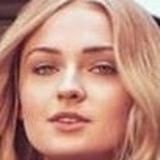

In [ ]:
from PIL import Image
import requests

url = 'https://datasets-server.huggingface.co/assets/lansinuote/simple_facenet/--/default/train/52/image/image.jpg'
image = Image.open(requests.get(url, stream=True).raw)
image

We'll load the feature extractor and model from the hub (here, we use the [Auto Classes](https://huggingface.co/docs/transformers/model_doc/auto#transformers.AutoModelForImageClassification), which will make sure the appropriate classes will be loaded automatically based on the `config.json` and `preprocessor_config.json` files of the repo on the hub):

In [ ]:
from transformers import TFAutoModelForImageClassification, AutoFeatureExtractor

repo_name = "SaladSlayer00/image_classification_resnet"

feature_extractor = AutoFeatureExtractor.from_pretrained(repo_name)
model = TFAutoModelForImageClassification.from_pretrained(repo_name)

preprocessor_config.json:   0%|          | 0.00/410 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/convnext/feature_extraction_convnext.py:28: FutureWarning: The class ConvNextFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ConvNextImageProcessor instead.
  warnings.warn(


config.json:   0%|          | 0.00/517k [00:00<?, ?B/s]

tf_model.h5:   0%|          | 0.00/237M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFResNetForImageClassification.

All the layers of TFResNetForImageClassification were initialized from the model checkpoint at SaladSlayer00/image_classification_resnet.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFResNetForImageClassification for predictions without further training.


In [ ]:
# prepare image for the model
encoding = feature_extractor(image.convert("RGB"), return_tensors="tf")
print(encoding.pixel_values.shape)

(1, 3, 224, 224)


In [ ]:
outputs = model(encoding)
logits = outputs.logits

In [ ]:
predicted_class_idx = tf.math.argmax(logits, -1).numpy()[0]
print("Predicted class:", model.config.id2label[predicted_class_idx])

Predicted class: Sophie Turner


Looks like our model got it correct!